# 📄 Extracting Text from Scientific Papers with Reporting

## 🔧 1. Setup

In [13]:
# Imports
import os
import pandas as pd
import sys
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure Python can find your scripts folder
sys.path.append("..")

# Import the functions
from scripts.pdf_reader import extract_full_text, extract_partial_text
from scripts.rename_pdfs import rename_pdfs_in_folder
from scripts.llm_extractor import extract_title_abstract_with_llm
from scripts.config_loader import load_config

# Create results and reports directories if they don't exist
os.makedirs("../results", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

# Load configuration with a specific profile
# Options: 'high_quality' or 'fast_processing' or None for default
# ⬇️ Decide which profile to use
config = load_config('fast_processing')  # Change this to use different profiles

# Print out some key configuration settings
print("🔍 Processing Configuration:")
print(f"LLM Model: {config.get('llm.model')}")
print(f"Page Limit for Metadata: {config.get('pdf.extraction.page_limit_for_metadata')}")
print(f"Extract Full Text: {config.get('pdf.extraction.full_text')}\n")

# Define batch
# ⬇️ Decide which batch to use
batch_name = "second_batch"

# Define prompt file
# ⬇️ Decide which prompt file to use
prompt_file = "title_abstract_prompts"  # Change this to use different prompts

# Import the selected prompts
prompt_module = __import__(f"prompts.{prompt_file}", fromlist=['SYSTEM_PROMPT', 'USER_PROMPT_TEMPLATE'])
SYSTEM_PROMPT = prompt_module.SYSTEM_PROMPT
USER_PROMPT_TEMPLATE = prompt_module.USER_PROMPT_TEMPLATE

print("�� Using prompts from:", prompt_file)

# Define folder paths using the configuration 
pdf_folder = os.path.join(config.get("paths.data_dir"), batch_name)
output_file = os.path.join(config.get("paths.output_dir"), f"{batch_name}.csv")

print(f"📂 PDF Folder: {pdf_folder}")
print(f"📄 Output File: {output_file}")

# Create a unique experiment ID based on timestamp and configuration
experiment_id = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

🔍 Processing Configuration:
LLM Model: gpt-3.5-turbo
Page Limit for Metadata: 2
Extract Full Text: True

�� Using prompts from: title_abstract_prompts
📂 PDF Folder: ../data/batches/second_batch
📄 Output File: ../outputs/second_batch.csv


### 🗂️ Load Configuration and Define Batch

In [2]:
# Load configuration with a specific profile
# Options: 'high_quality' or 'fast_processing' or None for default

# ⬇️ Decide which profile to use
config = load_config('high_quality')  # Change this to use different profiles

# Print out some key configuration settings
print("🔍 Processing Configuration:")
print(f"LLM Model: {config.get('llm.model')}")
print(f"Page Limit for Metadata: {config.get('pdf.extraction.page_limit_for_metadata')}")
print(f"Extract Full Text: {config.get('pdf.extraction.full_text')}\n")

# Define batch
# ⬇️ Decide which batch to use
batch_name = "second_batch"

# Define folder paths using the configuration 
pdf_folder = os.path.join(config.get("paths.data_dir"), batch_name)
output_file = os.path.join(config.get("paths.output_dir"), f"{batch_name}.csv")

print(f"📂 PDF Folder: {pdf_folder}")
print(f"📄 Output File: {output_file}")

# Create a unique experiment ID based on timestamp and configuration
experiment_id = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

🔍 Processing Configuration:
LLM Model: gpt-4o
Page Limit for Metadata: 5
Extract Full Text: True

📂 PDF Folder: ../data/batches/second_batch
📄 Output File: ../outputs/second_batch.csv


#### 🖋️ Rename the PDFs

In [3]:
# Rename PDFs using the configuration and get original filename mapping
renamed_files, original_filenames_map = rename_pdfs_in_folder(pdf_folder)
print(f"🔄 Renamed {len(renamed_files)} files")

# Show sample of original to new filename mapping
print("\n📋 Sample of original filenames:")
for i, (new_name, original_name) in enumerate(list(original_filenames_map.items())[:3]):
    print(f"  {new_name} ← {original_name}")
if len(original_filenames_map) > 3:
    print(f"  ... and {len(original_filenames_map) - 3} more")

🔄 Renamed 11 files

📋 Sample of original filenames:
  paper_001.pdf ← paper_001.pdf
  paper_002.pdf ← paper_002.pdf
  paper_003.pdf ← paper_003.pdf
  ... and 8 more


## 📜 2. Extract Text and Abstract

#### 🧪 Test Extraction

In [4]:
# Test extraction on a single PDF
if renamed_files:
    single_pdf_path = renamed_files[0]  # Use the first PDF
    
    print(f"🔬 Testing extraction on: {os.path.basename(single_pdf_path)}")
    
    # Get page limit from config
    page_limit = config.get("pdf.extraction.page_limit_for_metadata")
    print(f"📄 Using first {page_limit} pages for extraction")
    
    # Extract text
    partial_text = extract_partial_text(single_pdf_path, page_limit)
    print(f"📝 Extracted {len(partial_text)} characters of text")
    
    # Extract title, abstract, and confidence info
    title, abstract, confidence_info = extract_title_abstract_with_llm(partial_text)
    
    # Display results
    print("\n📊 Extraction Results:")
    print(f"Title: {title}")
    print(f"\nAbstract (first 300 chars): {abstract[:300]}...")
    
    # Display confidence information
    print("\n🎯 Confidence Scores:")
    print(f"  Title confidence: {confidence_info.get('title_score')}/5")
    print(f"  Abstract confidence: {confidence_info.get('abstract_score')}/5")
    print(f"  Explanation: {confidence_info.get('explanation')}")
    
    # Check for potential issues
    print("\n⚠️ Potential Issues:")
    if title == "EXTRACTION_FAILED":
        print("  - Title extraction failed")
    if abstract == "EXTRACTION_FAILED":
        print("  - Abstract extraction failed")
    if not title or not abstract:
        print("  - Empty title or abstract detected")
    if len(partial_text) < 100:
        print("  - Very little text extracted from PDF")
else:
    print("❌ No PDFs found to process")

🔬 Testing extraction on: paper_001.pdf
📄 Using first 5 pages for extraction
📝 Extracted 19322 characters of text

📊 Extraction Results:
Title: Implementation and evaluation of an additional GPT-4-based reviewer in PRISMA-based medical systematic literature reviews

Abstract (first 300 chars): Background: PRISMA-based literature reviews require meticulous scrutiny of extensive textual data by multiple reviewers, which is associated with considerable human effort. Objective: To evaluate feasibility and reliability of using GPT-4 API as a complementary reviewer in systematic literature revi...

🎯 Confidence Scores:
  Title confidence: 5/5
  Abstract confidence: 5/5
  Explanation: Both the title and abstract were clearly identified with explicit section headers labeled 'Title' and 'Abstract'. The structure and textual cues strongly indicate these sections.

⚠️ Potential Issues:


#### ✔️ Actual Extraction

In [5]:
# Initialize results tracking
results = {
    "total_papers": len(renamed_files),
    "successful_title_extractions": 0,
    "successful_abstract_extractions": 0,
    "failed_extractions": [],
    "error_patterns": {},
    "processing_times": []
}

# Process all PDFs
for i, pdf_path in enumerate(renamed_files, 1):
    print(f"Processing {i} of {len(renamed_files)}: {os.path.basename(pdf_path)}")
    
    try:
        # Get page limit from config
        page_limit = config.get("pdf.extraction.page_limit_for_metadata")
        partial_text = extract_partial_text(pdf_path, page_limit)
        
        # Extract title, abstract, and confidence info
        title, abstract, confidence_info = extract_title_abstract_with_llm(partial_text)
        
        # Update results
        if title and title != "EXTRACTION_FAILED":
            results["successful_title_extractions"] += 1
        if abstract and abstract != "EXTRACTION_FAILED":
            results["successful_abstract_extractions"] += 1
        
        # Track errors
        if title == "EXTRACTION_FAILED" or abstract == "EXTRACTION_FAILED":
            results["failed_extractions"].append({
                "file": os.path.basename(pdf_path),
                "title_failed": title == "EXTRACTION_FAILED",
                "abstract_failed": abstract == "EXTRACTION_FAILED"
            })
            
    except Exception as e:
        error_type = type(e).__name__
        if error_type not in results["error_patterns"]:
            results["error_patterns"][error_type] = 0
        results["error_patterns"][error_type] += 1
        results["failed_extractions"].append({
            "file": os.path.basename(pdf_path),
            "error": str(e)
        })

print(f"\n✅ Processed {len(renamed_files)} papers")

Processing 1 of 11: paper_001.pdf
Processing 2 of 11: paper_002.pdf
Processing 3 of 11: paper_003.pdf
Processing 4 of 11: paper_004.pdf
Processing 5 of 11: paper_005.pdf
Processing 6 of 11: paper_006.pdf
Processing 7 of 11: paper_007.pdf
Processing 8 of 11: paper_008.pdf
Processing 9 of 11: paper_009.pdf
Processing 10 of 11: paper_010.pdf
Processing 11 of 11: paper_011.pdf

✅ Processed 11 papers


## �� 3. Generate Report and Visualizations

In [ ]:
# Calculate success rates
title_success_rate = (results["successful_title_extractions"] / results["total_papers"]) * 100
abstract_success_rate = (results["successful_abstract_extractions"] / results["total_papers"]) * 100

# Initialize timing information
start_time = datetime.now()
extraction_times = []

# Create DataFrame with all extracted data
extracted_data = []
for i, pdf_path in enumerate(renamed_files):
    try:
        # Start timing for this extraction
        extraction_start = datetime.now()
        
        page_limit = config.get("pdf.extraction.page_limit_for_metadata")
        partial_text = extract_partial_text(pdf_path, page_limit)
        title, abstract, confidence_info = extract_title_abstract_with_llm(partial_text)
        
        # Calculate extraction time
        extraction_time = (datetime.now() - extraction_start).total_seconds()
        extraction_times.append(extraction_time)
        
        extracted_data.append({
            "document_id": os.path.basename(pdf_path),
            "original_filename": original_filenames_map.get(os.path.basename(pdf_path), ""),
            "title": title,
            "abstract": abstract,
            "title_confidence": confidence_info.get('title_score'),
            "abstract_confidence": confidence_info.get('abstract_score'),
            "confidence_explanation": confidence_info.get('explanation'),
            "raw_text": partial_text[:1000] + "..." if len(partial_text) > 1000 else partial_text,
            "extraction_time_seconds": extraction_time
        })
    except Exception as e:
        extraction_time = (datetime.now() - extraction_start).total_seconds()
        extraction_times.append(extraction_time)
        
        extracted_data.append({
            "document_id": os.path.basename(pdf_path),
            "original_filename": original_filenames_map.get(os.path.basename(pdf_path), ""),
            "title": "EXTRACTION_FAILED",
            "abstract": "EXTRACTION_FAILED",
            "title_confidence": 0,
            "abstract_confidence": 0,
            "confidence_explanation": str(e),
            "raw_text": "",
            "extraction_time_seconds": extraction_time
        })

# Calculate total processing time
total_processing_time = (datetime.now() - start_time).total_seconds()

# Convert to DataFrame
df = pd.DataFrame(extracted_data)

# Calculate timing statistics
avg_extraction_time = sum(extraction_times) / len(extraction_times)
min_extraction_time = min(extraction_times)
max_extraction_time = max(extraction_times)

# Save DataFrame to CSV
output_csv_path = os.path.abspath(f"../outputs/{experiment_id}_extracted_data.csv")
df.to_csv(output_csv_path, index=False)
print(f"📊 Extracted data saved to: {output_csv_path}")

# Prepare results dictionary with all information
full_results = {
    "experiment_id": experiment_id,
    "timestamp": datetime.now().isoformat(),
    "configuration": {
        "llm": {
            "model": config.get('llm.model'),
            "max_input_tokens": config.get('llm.max_input_tokens')
        },
        "pdf": {
            "extraction": {
                "page_limit_for_metadata": config.get('pdf.extraction.page_limit_for_metadata'),
                "full_text": config.get('pdf.extraction.full_text')
            }
        }
    },
    "prompts": {
        "prompt_file": prompt_file,
        "system_prompt": SYSTEM_PROMPT,
        "user_prompt_template": USER_PROMPT_TEMPLATE
    },
    "timing": {
        "total_processing_time_seconds": total_processing_time,
        "average_extraction_time_seconds": avg_extraction_time,
        "min_extraction_time_seconds": min_extraction_time,
        "max_extraction_time_seconds": max_extraction_time,
        "extraction_times_seconds": extraction_times
    },
    "results": {
        "total_papers": results['total_papers'],
        "successful_title_extractions": results["successful_title_extractions"],
        "successful_abstract_extractions": results["successful_abstract_extractions"],
        "title_success_rate": title_success_rate,
        "abstract_success_rate": abstract_success_rate,
        "failed_extractions": results["failed_extractions"],
        "error_patterns": results["error_patterns"]
    }
}

📊 Extracted data saved to: /Users/Zantana/repo/first-promo-paper/outputs/exp_20250415_091803_extracted_data.csv


In [10]:
# Ensure directories exist
os.makedirs("../reports", exist_ok=True)
os.makedirs("../results", exist_ok=True)

# Generate report
report = f"""# Experiment Report: {experiment_id}

## Configuration
- Model: {config.get('llm.model')}
- Max Input Tokens: {config.get('llm.max_input_tokens')}
- Page Limit for Metadata: {config.get('pdf.extraction.page_limit_for_metadata')}
- Extract Full Text: {config.get('pdf.extraction.full_text')}

## Prompts Used
### Prompt File: {prompt_file}
### System Prompt
{SYSTEM_PROMPT}

### User Prompt Template
{USER_PROMPT_TEMPLATE}

## Timing Information
- Total Processing Time: {total_processing_time:.2f} seconds
- Average Extraction Time: {avg_extraction_time:.2f} seconds
- Minimum Extraction Time: {min_extraction_time:.2f} seconds
- Maximum Extraction Time: {max_extraction_time:.2f} seconds

## Results
- Total Papers Processed: {results['total_papers']}
- Title Extraction Success Rate: {title_success_rate:.2f}%
- Abstract Extraction Success Rate: {abstract_success_rate:.2f}%

## Data Output
- Extracted data saved to: {output_csv_path}
- Number of rows in output: {len(df)}
- Number of successful extractions: {len(df[df['title'] != 'EXTRACTION_FAILED'])}
- Number of failed extractions: {len(df[df['title'] == 'EXTRACTION_FAILED'])}

## Error Analysis
### Failed Extractions
Total Failed: {len(results['failed_extractions'])}

### Error Patterns
"""
for error_type, count in results["error_patterns"].items():
    report += f"- {error_type}: {count} occurrences\n"

report += "\n## Observations\n"
if results["failed_extractions"]:
    report += "### Common Failure Patterns:\n"
    for failure in results["failed_extractions"][:3]:  # Show first 3 failures
        report += f"- {failure['file']}: "
        if 'error' in failure:
            report += f"Error: {failure['error']}\n"
        else:
            if failure.get('title_failed'):
                report += "Title extraction failed"
            if failure.get('abstract_failed'):
                report += "Abstract extraction failed"
            report += "\n"

# Save report with absolute path
report_path = os.path.abspath(f"../reports/{experiment_id}.md")
with open(report_path, "w") as f:
    f.write(report)
print(f"📝 Report saved to: {report_path}")

# Save results with absolute path
results_path = os.path.abspath(f"../results/{experiment_id}_results.json")
with open(results_path, "w") as f:
    json.dump(full_results, f, indent=2)
print(f"📊 Results saved to: {results_path}")

# Display sample of the extracted data
print("\n📋 Sample of extracted data:")
display(df.head())

📝 Report saved to: /Users/Zantana/repo/first-promo-paper/reports/exp_20250415_091803.md
📊 Results saved to: /Users/Zantana/repo/first-promo-paper/results/exp_20250415_091803_results.json

📋 Sample of extracted data:


,document_id,original_filename,title,abstract,title_confidence,abstract_confidence,confidence_explanation,raw_text,extraction_time_seconds
0,paper_001.pdf,paper_001.pdf,Implementation and evaluation of an additional...,Background: PRISMA-based literature reviews re...,5,5,The title and abstract were clearly identified...,InternationalJournalofMedicalInformatics189(20...,6.770239
1,paper_002.pdf,paper_002.pdf,Automating Systematic Literature Reviews with ...,Objectives: An SLR is presented focusing on te...,5,5,The title and abstract were clearly identified...,"Preprint of: Sundaram, G. and Berleant, D., Au...",4.292977
2,paper_003.pdf,paper_003.pdf,Cutting Through the Clutter: The Potential of ...,"In academic research, systematic literature re...",5,5,The title and abstract were clearly identifiab...,Cutting Through the Clutter: The Potential of ...,6.575895
3,paper_004.pdf,paper_004.pdf,Can large language models replace humans in sy...,Systematic reviews are vital for guiding pract...,5,5,The title and abstract were clearly identified...,Received:10October2023 Revised:6February2024 A...,4.921294
4,paper_005.pdf,paper_005.pdf,Title and abstract screening for literature re...,Background Systematically screening published ...,5,5,The title and abstract were clearly identified...,Dennstädt et al. Systematic Reviews (2024) 13:...,5.467513


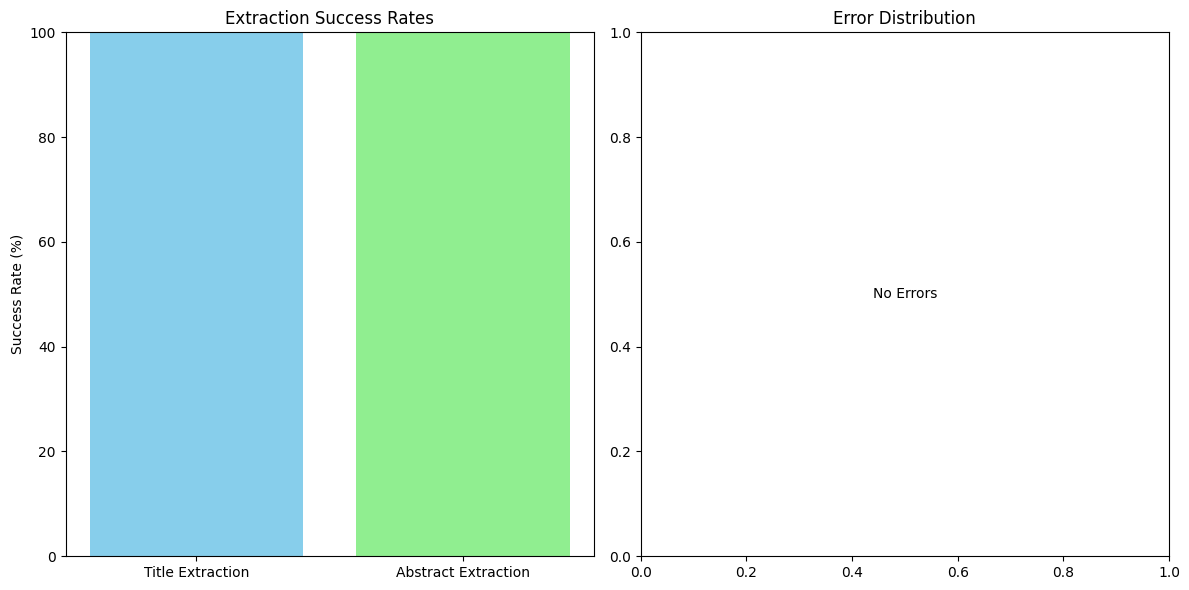

In [11]:
# Create visualizations
plt.figure(figsize=(12, 6))

# Success rates bar plot
plt.subplot(1, 2, 1)
success_rates = [title_success_rate, abstract_success_rate]
labels = ['Title Extraction', 'Abstract Extraction']
plt.bar(labels, success_rates, color=['skyblue', 'lightgreen'])
plt.title('Extraction Success Rates')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 100)

# Error patterns pie chart
plt.subplot(1, 2, 2)
if results["error_patterns"]:
    error_types = list(results["error_patterns"].keys())
    error_counts = list(results["error_patterns"].values())
    plt.pie(error_counts, labels=error_types, autopct='%1.1f%%')
    plt.title('Error Distribution')
else:
    plt.text(0.5, 0.5, 'No Errors', ha='center', va='center')
    plt.title('Error Distribution')

plt.tight_layout()
plt.savefig(f"../reports/{experiment_id}_visualization.png")
plt.show()